## Embedding Fashion MNIST 

We begin by importing the libraries that we'll need.  Mainly we'll be using NumPy and Keras (with TensorFlow backend).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

import gzip
import os
import keras
from keras.datasets import fashion_mnist, mnist


%matplotlib notebook

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


The Fashion MNIST dataset contains grayscale images of articles of clothing.  It is meant as a drop-in replacement for MNIST but it is a more challenging dataset.

In [48]:
(x_train, y_train_og), (x_test, y_test_og) = fashion_mnist.load_data()

In [49]:
(x_train, x_valid) = x_train[5000:], x_train[:5000] 
(y_train, y_valid) = y_train_og[5000:], y_train_og[:5000]
y_test = y_test_og

In [50]:
x_train = np.expand_dims(x_train,axis=3)
x_test = np.expand_dims(x_test,axis=3)
x_valid = np.expand_dims(x_valid,axis=3)

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
x_valid = x_valid.astype('float32') / 255

In [51]:
x_train.shape

(55000, 28, 28, 1)

In [52]:
# One-hot encode the labels
y_train = keras.utils.to_categorical(y_train, 10)
y_valid = keras.utils.to_categorical(y_valid, 10)
y_test = keras.utils.to_categorical(y_test, 10)

## Clothing Categories with Different Color Maps

Now, let's visualize Fashion MNIST using [color maps](https://matplotlib.org/examples/color/colormaps_reference.html).  This can help us humans get a better understanding of our data.

In [53]:
(x_train_OG, y_train_OG), (_, __) = fashion_mnist.load_data()

In [54]:
mnist_indsToShow = [7286, 3, 5, 10, 2, 8252, 22665, 44257, 55061, 58179]
mnist_textLabels = ['zero', 'one', 'two', 'three', 'four', 'fize', 'six', 'seven', 'eight', 'nine']

fmnist_textLabels = ['T-Shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Purse', 'Ankle-Boot']
fmnist_indsToShow = [1 , 2265, 44257, 3, 8252, 18063, 22665, 6, 1957, 11] #11

def label_demo( data, colorMap='gray', figSize=(13,7), dataset='fmnist', fontSize='15' ):
    
    plt.figure( figsize = figSize)
    
    if dataset == 'fmnist':
        indexesToShow = fmnist_indsToShow
        textLabels = fmnist_textLabels
    else:
        indexesToShow = mnist_indsToShow
        textLabels = mnist_textLabels
        
    majorTicks = np.arange(0, 28, 4)
    minorTicks = np.arange(0, 28, 1)

    for iCategory in range ( len(textLabels)):
        ax = plt.subplot(2, 5, iCategory+1)
        
        ax.set_xticks(minorTicks, minor=True)
        ax.set_yticks(minorTicks, minor=True)
        ax.set_xticks(majorTicks)
        ax.set_yticks(majorTicks)
        
        plt.imshow(np.squeeze(data[indexesToShow[iCategory]]), cmap = colorMap); plt.axis('off')
        
        ax.grid(which='minor', alpha=0.1, color='g')
        ax.grid(which='major', alpha=.5, linestyle='dotted', color='y')
        
        plt.subplots_adjust( left = 0.05, right = 0.95, top = 0.95, bottom = 0.05, wspace = 0.01 )
        plt.title(str(iCategory) + ': ' + textLabels[iCategory], fontsize = fontSize)
        
    plt.show()

<IPython.core.display.Javascript object>


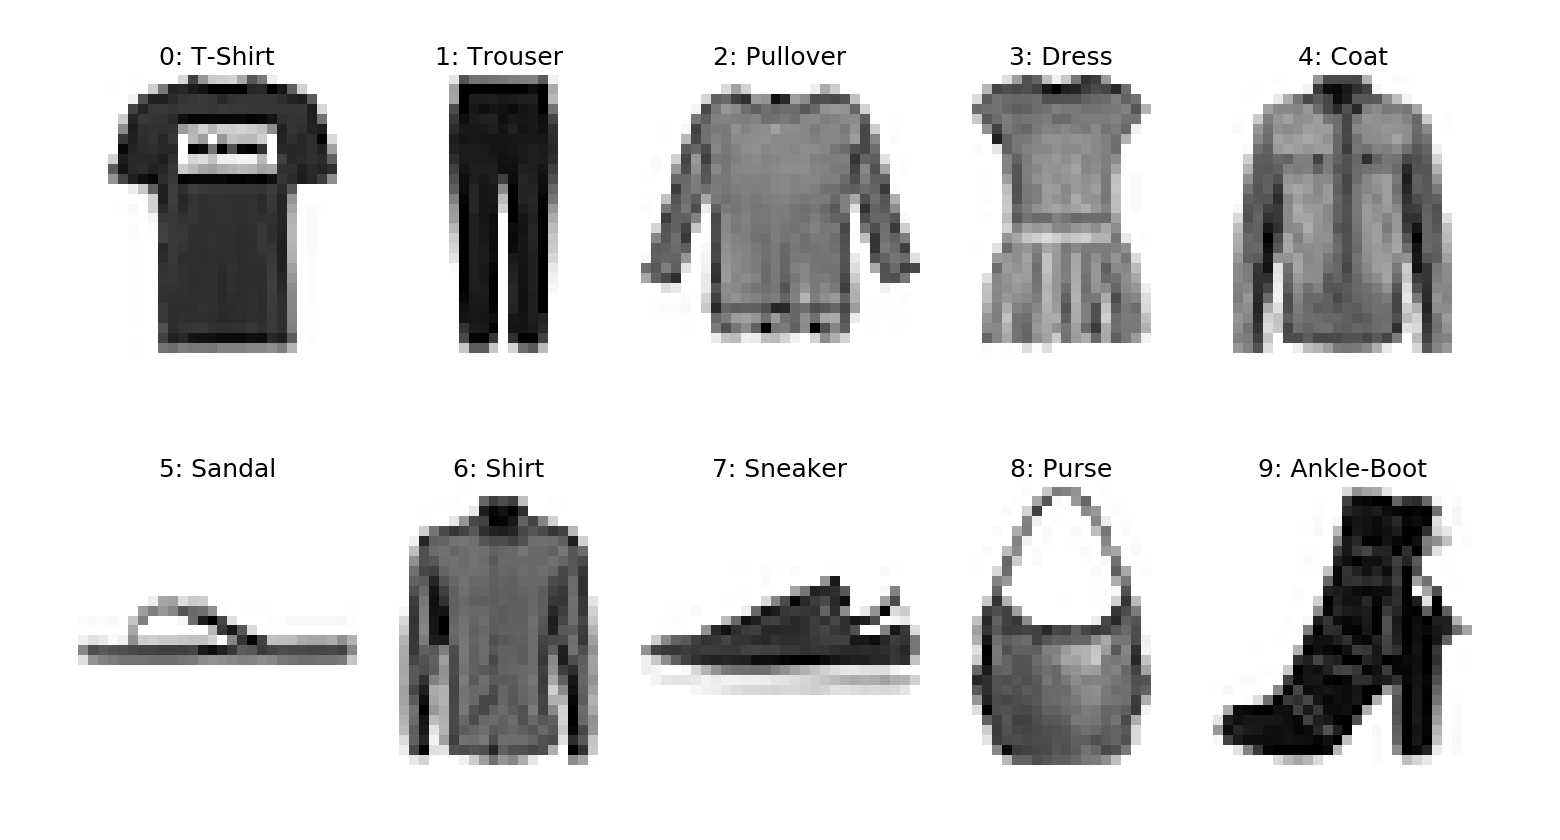

<IPython.core.display.Javascript object>


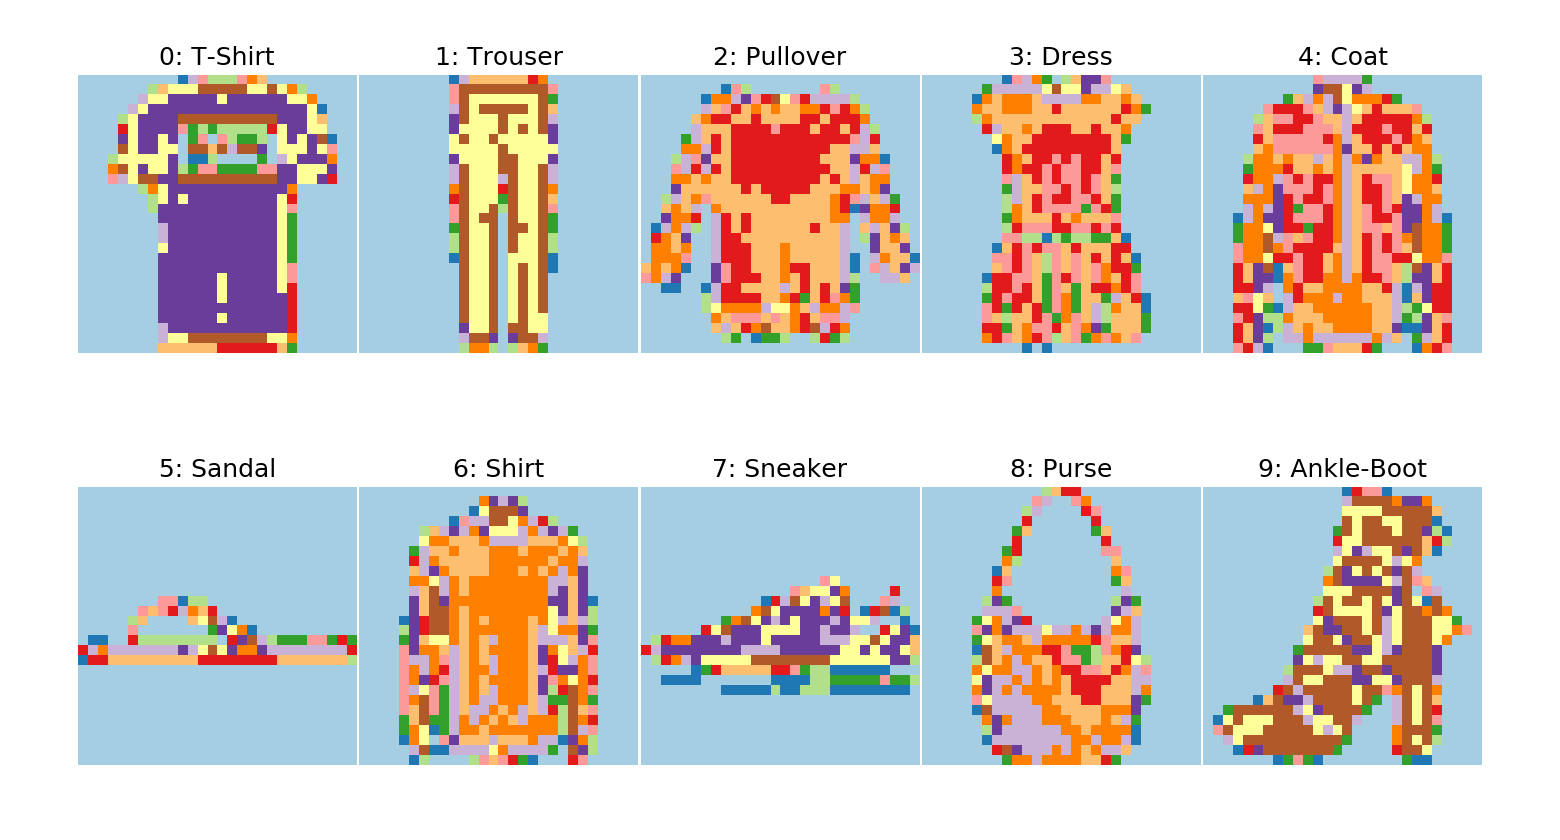

In [55]:
label_demo(x_train_OG, 'binary', dataset='fmnist');
label_demo(x_train_OG, 'Paired', dataset='fmnist')

## Visualize Random Samples from the Dataset

Now, let's inspect the data and see what we're working with.  It's a good idea to first plot and try to visualize your data.

In [56]:
inds = np.where(y_train_og[:]==7)[0]

In [57]:
inds

array([    6,    14,    41, ..., 59951, 59979, 59992], dtype=int64)

<IPython.core.display.Javascript object>


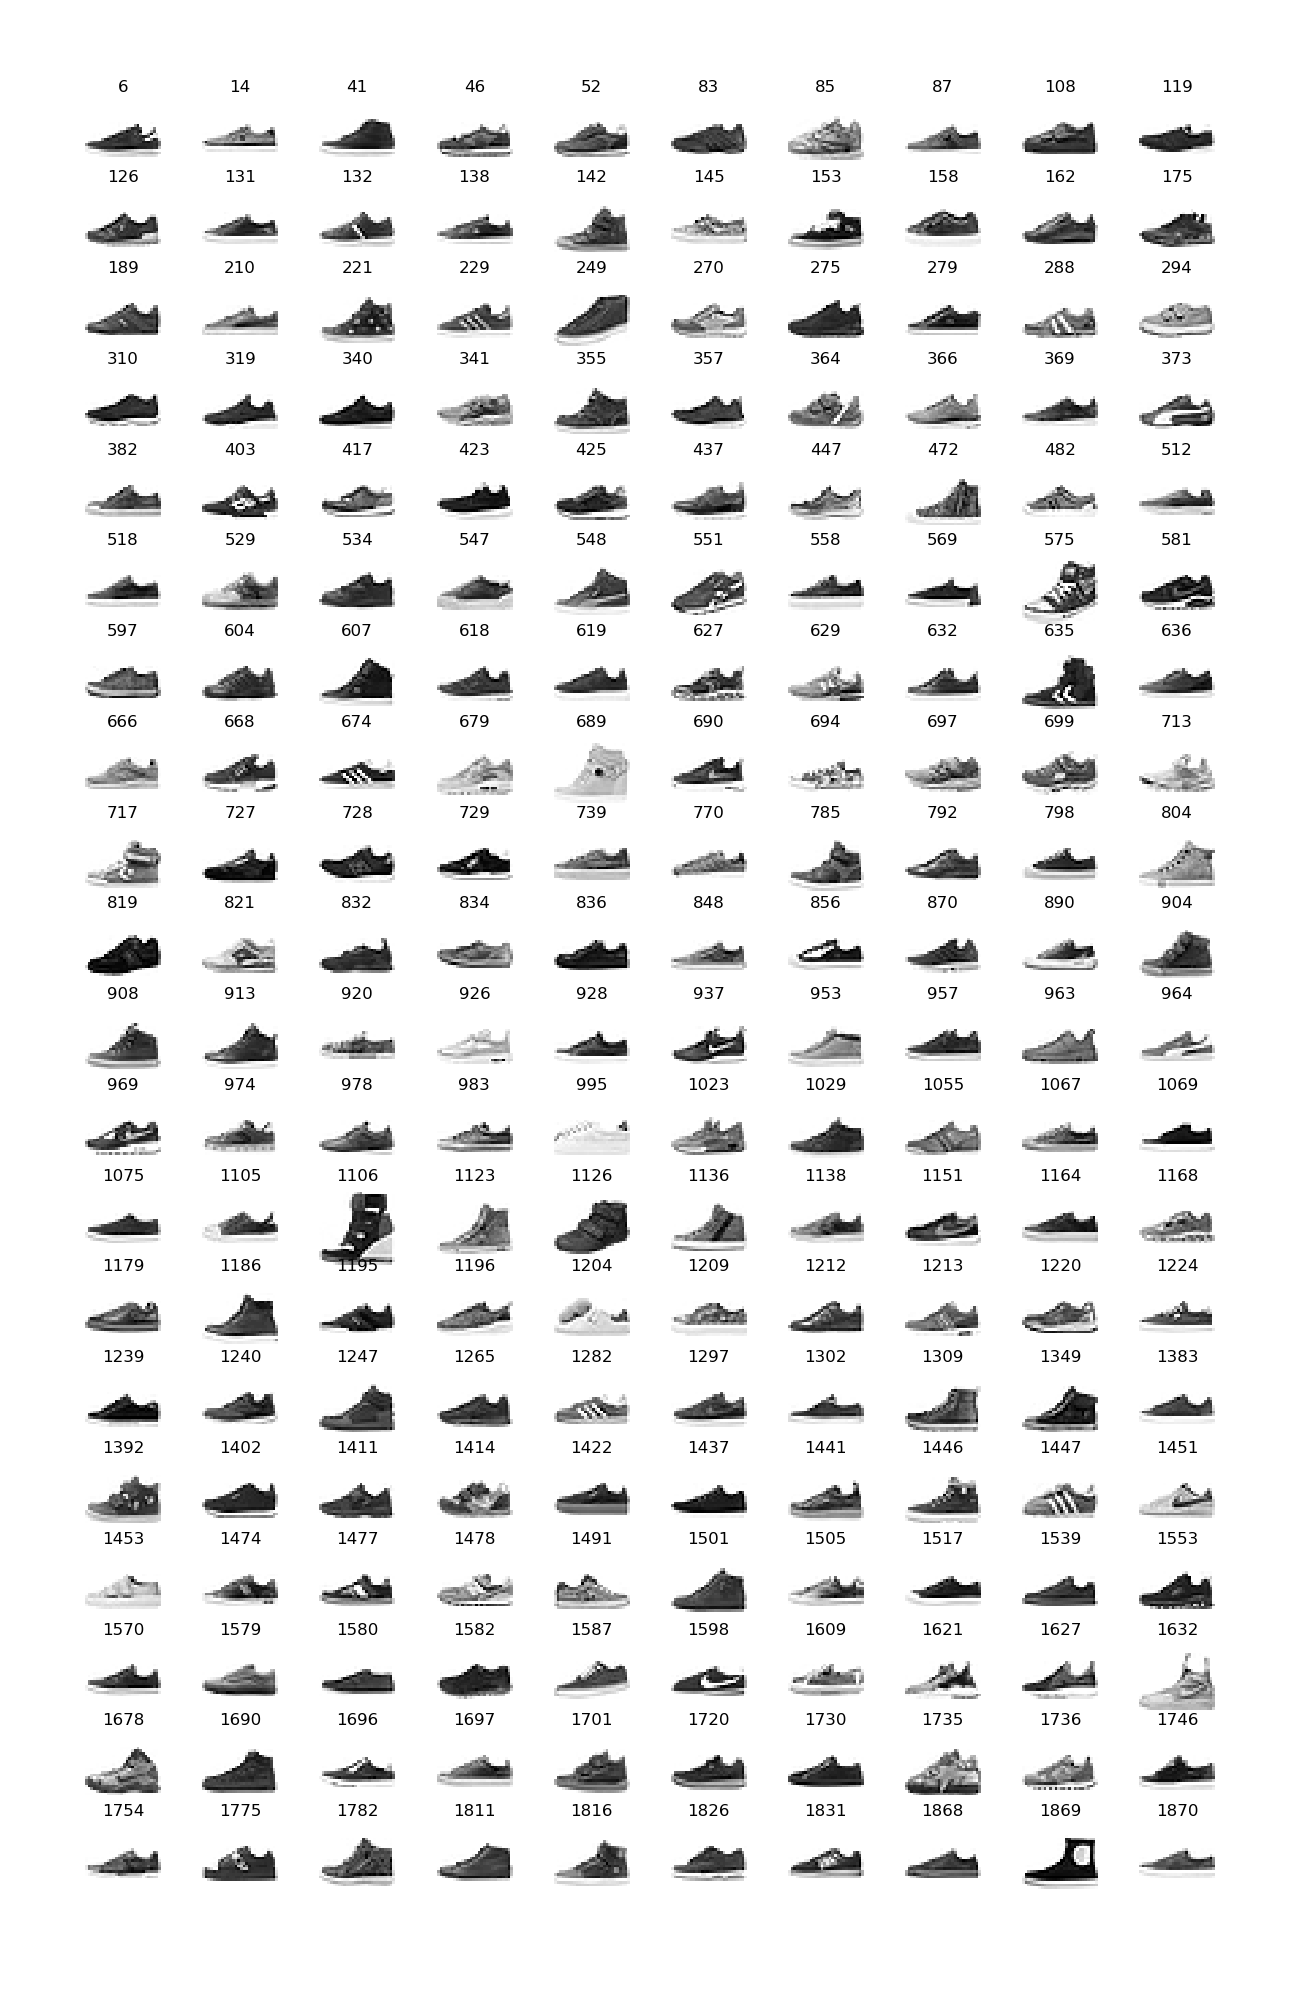

In [58]:
plt.figure(figsize=(13,20))
plt.subplots_adjust( left = 0.05, right = 0.95, top = 0.95, bottom = 0.05, wspace = 0.01 )
#inds = [7286]
for i in range(200):
    plt.subplot(20,10,i+1)
    plt.imshow(np.squeeze(x_train_OG[inds[i]]), cmap='binary'); plt.axis('off')
    plt.title(inds[i])

plt.show()

## Examples of Questionable Labels 
477 ankle boot

1869 sneaker

3755 pullover


## CNN Model

In [59]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.models import Model
inputImages = Input ( shape=(28,28,1) )

conv1 = Conv2D ( filters = 64,
                 kernel_size=2,
                 padding='same',
                 activation='relu' )( inputImages )
mpool1 = MaxPooling2D()( conv1 )
dropout1 = Dropout(0.3)( mpool1)

conv2 = Conv2D ( filters = 64, 
                 kernel_size=2, 
                 padding='same', 
                 activation='relu' )( dropout1 )
mpool2 = MaxPooling2D( pool_size = 2 )( conv2 )
dropout2 = Dropout( 0.3 )( mpool2 )

flattenedRep = Flatten()( dropout2 )
internalRepresentation = Dense( 256, activation = 'relu')( flattenedRep )
dropout3 = Dropout(0.5)( internalRepresentation )
predictions = Dense(10, activation='softmax')(dropout3)


model = Model (inputs = inputImages, outputs = predictions)
embeddings = Model ( inputs = inputImages, outputs = internalRepresentation)


In [60]:
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])
embeddings.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

In [61]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 64)        320       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 64)        16448     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 7, 7, 64)          0         
__________

In [62]:
embeddings.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 64)        320       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 64)        16448     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 7, 7, 64)          0         
__________

In [63]:
x_train.shape

(55000, 28, 28, 1)

In [64]:
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath='model-bak.weights.best.hdf5', verbose = 1, save_best_only=True)
model.fit(x_train, y_train, batch_size=64, epochs=10, validation_data=(x_valid, y_valid), callbacks=[checkpointer])  

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 10s 174us/step - loss: 0.5711 - acc: 0.7920 - val_loss: 0.3446 - val_acc: 0.8800

Epoch 00001: val_loss improved from inf to 0.34458, saving model to model-bak.weights.best.hdf5
Epoch 2/10
55000/55000 [==============================] - 9s 165us/step - loss: 0.3865 - acc: 0.8600 - val_loss: 0.3057 - val_acc: 0.8914

Epoch 00002: val_loss improved from 0.34458 to 0.30568, saving model to model-bak.weights.best.hdf5
Epoch 3/10
55000/55000 [==============================] - 9s 167us/step - loss: 0.3404 - acc: 0.8760 - val_loss: 0.2703 - val_acc: 0.9008

Epoch 00003: val_loss improved from 0.30568 to 0.27030, saving model to model-bak.weights.best.hdf5
Epoch 4/10
55000/55000 [==============================] - 9s 167us/step - loss: 0.3127 - acc: 0.8854 - val_loss: 0.2558 - val_acc: 0.9086

Epoch 00004: val_loss improved from 0.27030 to 0.25582, saving model to model-bak.weights.best.hdf

In [65]:
# Evaluate the model on test set
score = model.evaluate(x_test, y_test, verbose=0)

# Print test accuracy
print('\n', 'Test accuracy:', score[1])


 Test accuracy: 0.914


In [66]:
# Load the weights with the best validation accuracy
model.load_weights('model.weights.best.hdf5')

In [68]:
%matplotlib inline

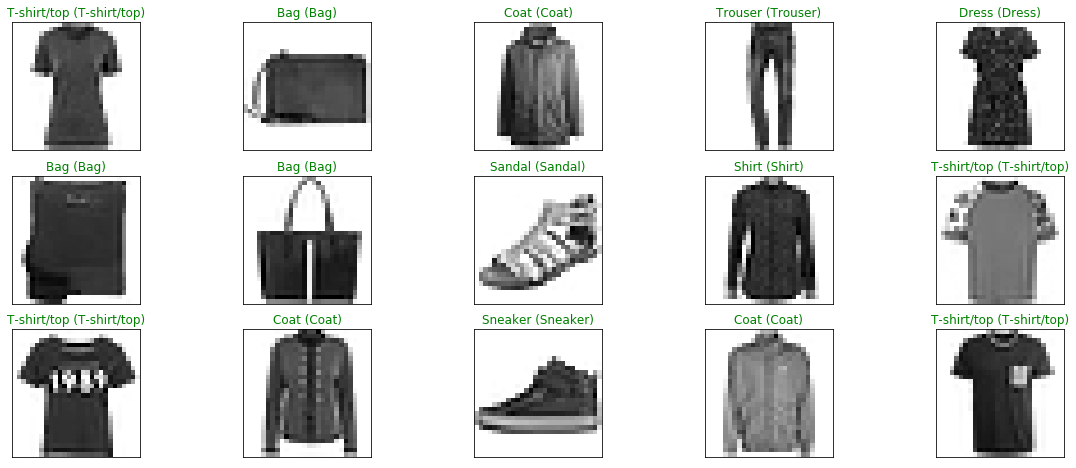

In [70]:
y_hat = model.predict(x_test)
# Define the text labels
fashion_mnist_labels = ["T-shirt/top",  # index 0
                        "Trouser",      # index 1
                        "Pullover",     # index 2 
                        "Dress",        # index 3 
                        "Coat",         # index 4
                        "Sandal",       # index 5
                        "Shirt",        # index 6 
                        "Sneaker",      # index 7 
                        "Bag",          # index 8 
                        "Ankle boot"]   # index 9
# Plot a random sample of 10 test images, their predicted labels and ground truth
figure = plt.figure(figsize=(20, 8))
for i, index in enumerate(np.random.choice(x_test.shape[0], size=15, replace=False)):
    ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    # Display each image
    ax.imshow(np.squeeze(x_test[index]),cmap='binary')
    predict_index = np.argmax(y_hat[index])
    true_index = np.argmax(y_test[index])
    # Set the title for each image
    ax.set_title("{} ({})".format(fashion_mnist_labels[predict_index], 
                                  fashion_mnist_labels[true_index]),
                                  color=("green" if predict_index == true_index else "red"))

In [22]:
y_hat = model.predict(x_test)

In [23]:
y_hat.shape

(10000, 10)

In [24]:
z_hat = embeddings.predict(x_test)

In [25]:
z_hat.shape

(10000, 256)

In [ ]:
import os
import tensorflow as tf
from tensorflow.contrib.tensorboard.plugins import projector


LOG_DIR = 'C:\\Dropbox\\nvidia\\engagement_logs\\nike\\logs'
metadata = os.path.join(LOG_DIR, 'metadata.tsv')

images = tf.Variable(z_hat, name='embedding')


with open(metadata, 'w') as metadata_file:
    for i in y_test_og:
        metadata_file.write('%d\n' % i)
        
with tf.Session() as sess:
    saver = tf.train.Saver([images])

    sess.run(images.initializer)
    saver.save(sess, os.path.join(LOG_DIR, 'emb.ckpt'))

    config = projector.ProjectorConfig()
    # One can add multiple embeddings.
    embedding = config.embeddings.add()
    embedding.tensor_name = images.name
    # Link this tensor to its metadata file (e.g. labels).
    embedding.metadata_path = metadata
    # Saves a config file that TensorBoard will read during startup.
    projector.visualize_embeddings(tf.summary.FileWriter(LOG_DIR), config)

In [26]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
pca = PCA(n_components = 3)
PCA_bottleneckActivations = pca.fit_transform(z_hat)

In [27]:
import mpld3
from mpld3 import plugins, utils
from mpl_toolkits.mplot3d import Axes3D
%matplotlib ipympl
# https://github.com/matplotlib/jupyter-matplotlib

<IPython.core.display.Javascript object>


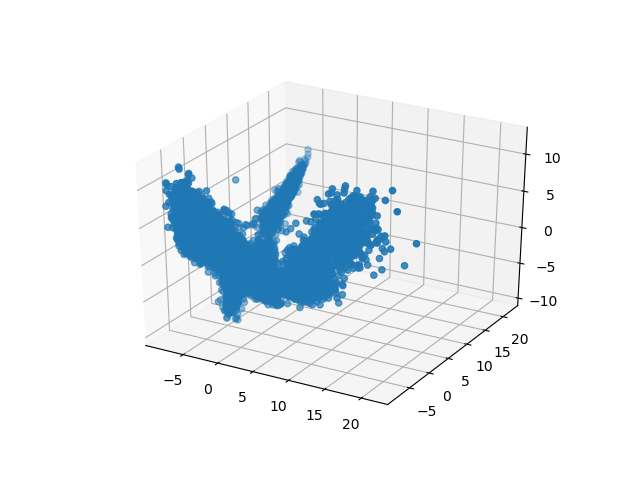

In [28]:
ax = plt.subplot(1,1,1, projection='3d')
ax.scatter(PCA_bottleneckActivations[:, 0], PCA_bottleneckActivations[:,1], PCA_bottleneckActivations[:,2])

#plt.scatter(PCA_bottleneckActivations[:, 0], PCA_bottleneckActivations[:,1])

## Autoencoders

In [29]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

x_train_flat = np.reshape(x_train, (x_train.shape[0], 28*28))
x_test_flat = np.reshape(x_test, (x_test.shape[0], 28*28))

x_train_flat = x_train_flat.astype('float32') / 255
x_test_flat = x_test_flat.astype('float32') / 255

In [30]:
x_train_flat.shape

(60000, 784)

In [31]:
dataShape = x_train_flat.shape[1]

In [32]:
AE_model = keras.models.Sequential()

In [33]:
AE_model.add( keras.layers.Dense(dataShape//2, input_shape=(dataShape,), activation='linear') )
AE_model.add( keras.layers.Dense(dataShape//4, activation='relu' ) )
AE_model.add( keras.layers.Dense(dataShape//8, activation='relu' ) )
AE_model.add( keras.layers.Dense(dataShape//16, activation='relu' ) )
AE_model.add( keras.layers.Dense(dataShape//8, activation='relu' ) )
AE_model.add( keras.layers.Dense(dataShape//4, activation='relu' ) )
AE_model.add( keras.layers.Dense(dataShape//2, activation='relu' ) )
AE_model.add( keras.layers.Dense(dataShape, activation='linear') )

In [34]:
AE_model.compile( loss='mse', optimizer='adam' )

In [35]:
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath='AE_model.weights.best.hdf5', verbose = 1, save_best_only=True)
AE_model.fit(x_train_flat, x_train_flat, batch_size=64, epochs=30, validation_data=(x_test_flat, x_test_flat), callbacks=[checkpointer])

Train on 60000 samples, validate on 10000 samples
Epoch 1/30
60000/60000 [==============================] - 7s 117us/step - loss: 0.0230 - val_loss: 0.0161

Epoch 00001: val_loss improved from inf to 0.01611, saving model to AE_model.weights.best.hdf5
Epoch 2/30
60000/60000 [==============================] - 7s 109us/step - loss: 0.0149 - val_loss: 0.0141

Epoch 00002: val_loss improved from 0.01611 to 0.01414, saving model to AE_model.weights.best.hdf5
Epoch 3/30
60000/60000 [==============================] - 7s 111us/step - loss: 0.0132 - val_loss: 0.0129

Epoch 00003: val_loss improved from 0.01414 to 0.01291, saving model to AE_model.weights.best.hdf5
Epoch 4/30
60000/60000 [==============================] - 7s 110us/step - loss: 0.0124 - val_loss: 0.0122

Epoch 00004: val_loss improved from 0.01291 to 0.01215, saving model to AE_model.weights.best.hdf5
Epoch 5/30
60000/60000 [==============================] - 7s 112us/step - loss: 0.0119 - val_loss: 0.0117

Epoch 00005: val_loss i

In [36]:
x_train_flat[0].shape

(784,)

In [37]:
# Load the weights with the best validation accuracy
AE_model.load_weights('AE_model.weights.best.hdf5')

In [38]:
reconstructions = AE_model.predict(x_train_flat)

In [39]:
reconstructions[0].shape

(784,)

In [40]:
784/16

49.0

<IPython.core.display.Javascript object>


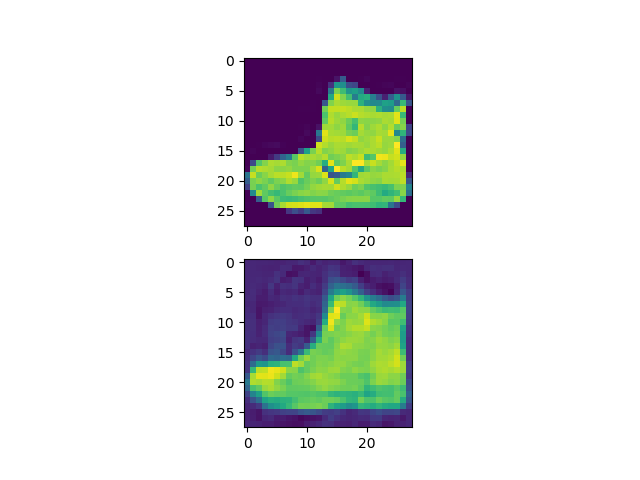

<IPython.core.display.Javascript object>


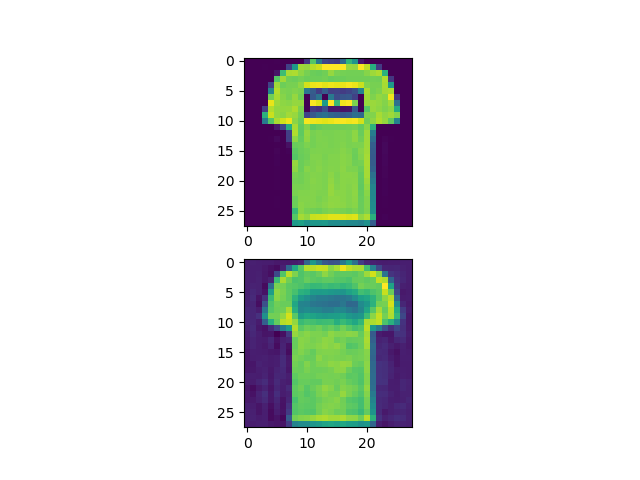

<IPython.core.display.Javascript object>


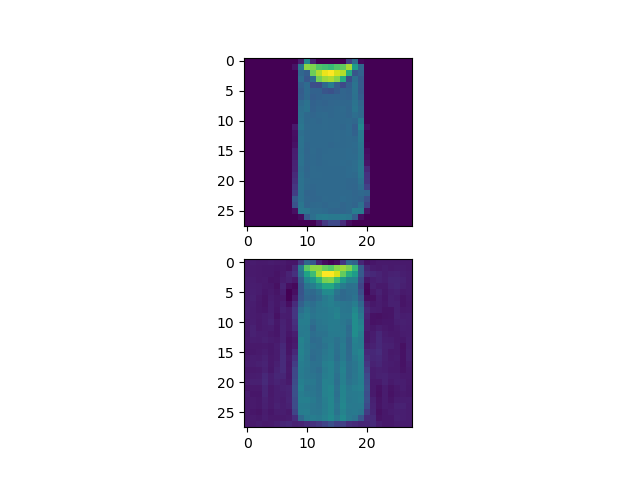

<IPython.core.display.Javascript object>


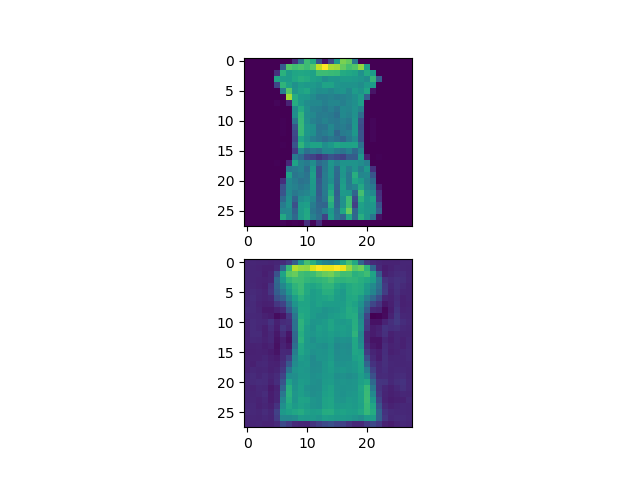

<IPython.core.display.Javascript object>


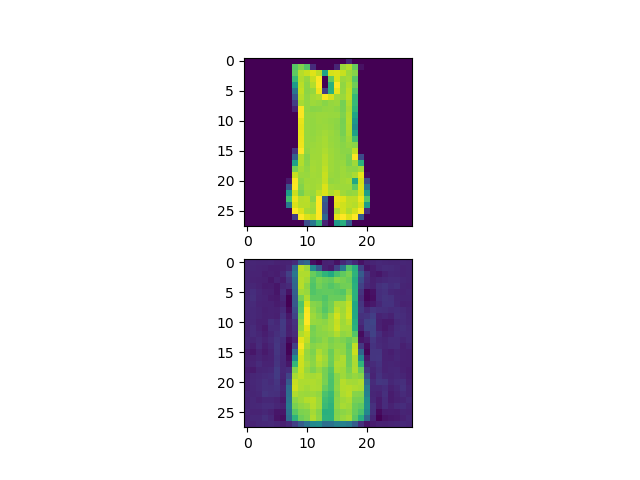

<IPython.core.display.Javascript object>


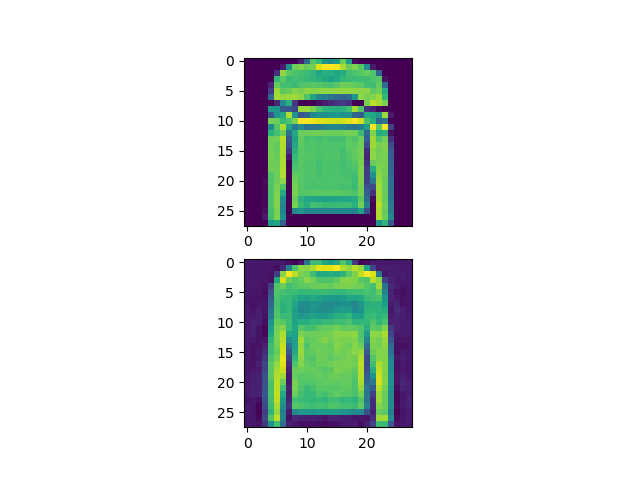

<IPython.core.display.Javascript object>


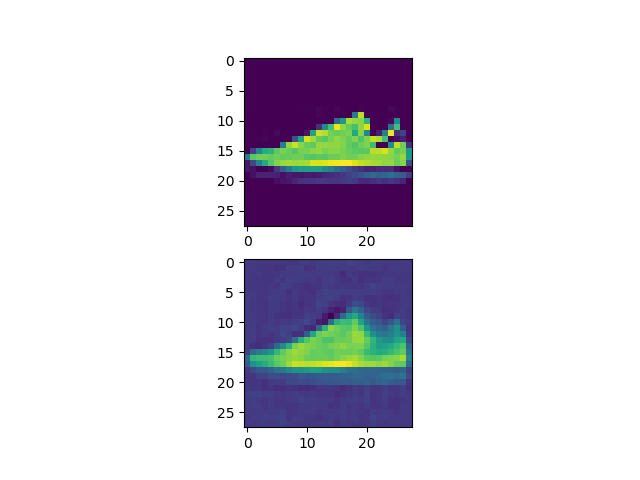

<IPython.core.display.Javascript object>


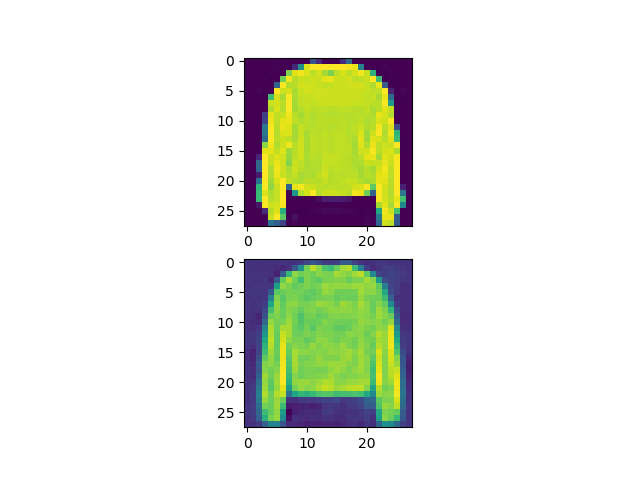

<IPython.core.display.Javascript object>


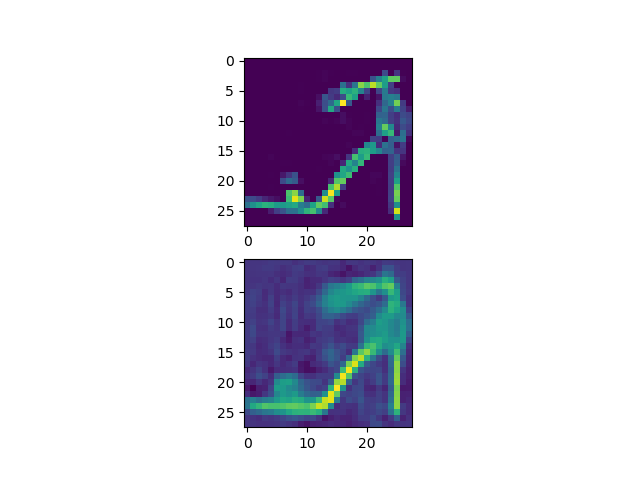

<IPython.core.display.Javascript object>


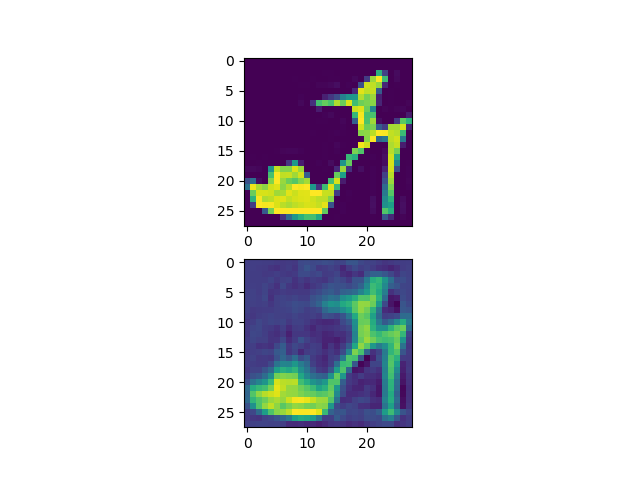

In [41]:
for i in range (10):
    plt.figure()
    plt.subplot(2,1,1)
    plt.imshow(np.reshape(x_train_flat[i],(28,28)))
    plt.subplot(2,1,2)
    plt.imshow(np.reshape(reconstructions[i],(28,28)))
    plt.show()

In [ ]:
AE_model.summary()

In [ ]:
AE_model.pop() # 4x

In [71]:
bottleneckActivations = AE_model.predict(x_train_flat)

In [72]:
bottleneckActivations.shape

(60000, 784)

In [73]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
pca = PCA(n_components = 3)
PCA_bottleneckActivations = pca.fit_transform(bottleneckActivations)

In [74]:
import mpld3
from mpld3 import plugins, utils
from mpl_toolkits.mplot3d import Axes3D
%matplotlib ipympl
# https://github.com/matplotlib/jupyter-matplotlib

<IPython.core.display.Javascript object>


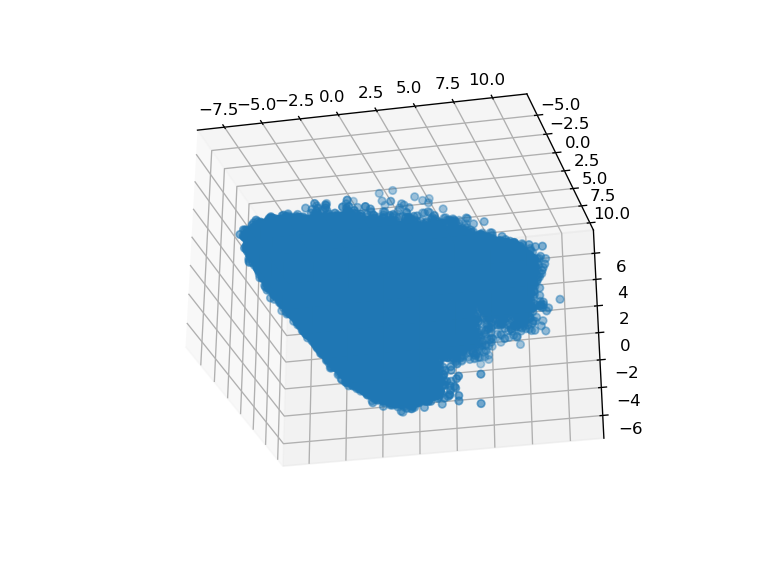

In [75]:
ax = plt.subplot(1,1,1, projection='3d')
ax.scatter(PCA_bottleneckActivations[:, 0], PCA_bottleneckActivations[:,1], PCA_bottleneckActivations[:,2])

#plt.scatter(PCA_bottleneckActivations[:, 0], PCA_bottleneckActivations[:,1])